In [1]:
from pyscf import gto, scf, fci, mcscf
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
import os
from qiskit import transpile
from qiskit_aer import AerSimulator, AerProvider
from math import comb
import time
import numpy as np
from scipy.sparse import csr_matrix


from scipy.sparse.linalg import eigsh
from qiskit_ibm_runtime import QiskitRuntimeService


## 함수

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
    token='Wx06bez50boLXEdw3IbqpoDa8gwHcURc9lQT0D_SRxJP', # Your token is confidential.
    # Do not share your key in public code.
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/624a449c58db4cebbbcd6d44cd96889e:354c61a9-e812-433b-a108-1e267e668f64::",
    name=".", # Optionally name this set of account credentials.
    set_as_default=True, # Optionally set these as your default credentials.
    overwrite=True
  )

In [3]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_fez")
backend = AerSimulator(method = "statevector",noise_model=None)

In [4]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper
    # 고전값 비교용 FCI 
    # H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
    
def hamming_distance(state1, state2):
    """Number of differing bits"""
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def apply_pauli_string(state, pauli_string):
    """
    state: "010101..." (ket)
    pauli_string: "XIZY..."
    
    Returns:
        (new_state, phase factor)
    """
    state_list = list(state)
    phase = 1.0

    for i, p in enumerate(pauli_string):
        if p == 'I':
            continue
        elif p == 'Z':
            if state[i] == '1':
                phase *= -1
        elif p == 'X':
            # X → flip
            state_list[i] = '1' if state[i] == '0' else '0'
        elif p == 'Y':
            # Y → flip + phase
            if state[i] == '0':
                phase *= 1j
            else:
                phase *= -1j
            state_list[i] = '1' if state[i] == '0' else '0'

    new_state = ''.join(state_list)
    return new_state, phase

def binary_string_to_sparse_state(bitstring):
    """
    binary string (예: '1000') → sparse state vector (CSR matrix)
    """
    n = len(bitstring)
    dim = 2 ** n
    index = int(bitstring, 2)  # binary string → 정수 인덱스

    # 상태벡터: 0으로 초기화 후, 해당 위치만 1
    state = np.zeros((1, dim), dtype=complex)
    state[0, index] = 1.0

    # 희소 행렬로 변환 (row vector 형태)
    sparse_state = csr_matrix(state)
    return sparse_state


def inner_product_pauli_hamiltonian(pauli_op, basis_bra, basis_ket):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.

    pauli_op: PauliSumOp or similar (e.g. Qiskit's PauliSumOp.to_list())
    basis_bra, basis_ket: "010101..." strings
    
    Returns: float (real part of <bra|H|ket>)
    """
    pauli_matrix = pauli_op.to_matrix(sparse=True)
    state_bra = binary_string_to_sparse_state(basis_bra)
    state_ket = binary_string_to_sparse_state(basis_ket)
    y = state_bra @ pauli_matrix            # 1×16
    result = y @ state_ket.getH()
    
    return result[0,0]

def project_hamiltonian(basis,hamiltonian):
    n = len(basis)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = basis[i]
            basis_ket = basis[j]
            inner_product = inner_product_pauli_hamiltonian(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 

            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    return H 

def particle_count(s):
    n = len(s)
    half = n // 2
    left = s[:half].count('1')
    right = s[half:].count('1')
    return left, right

def flip_one_pair(s, zero_idx, one_idx):
    """
    문자열 s에서 zero_idx는 '0'이어야 하고 → '1'로 바꾸고,
    one_idx는 '1'이어야 하고 → '0'으로 바꿈
    """
    s = list(s)
    assert s[zero_idx] == '0', f"Index {zero_idx} is not 0"
    assert s[one_idx] == '1', f"Index {one_idx} is not 1"
    s[zero_idx] = '1'
    s[one_idx] = '0'
    return ''.join(s)

def one_step_states_constrained(s):
    """1번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    zeros = [i for i, c in enumerate(s) if c == '0']
    ones = [i for i, c in enumerate(s) if c == '1']
    target_left, target_right = particle_count(s)

    states = set()
    for zi in zeros:
        for oi in ones:
            if zi == oi:
                continue
            new_s = flip_one_pair(s, zi, oi)
            l, r = particle_count(new_s)
            if l == target_left and r == target_right:
                states.add(new_s)
    return states

def two_step_states_constrained(s):
    """2번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    step1 = one_step_states_constrained(s)
    states = set()
    for inter in step1:
        states.update(one_step_states_constrained(inter))
    states.discard(s)  # 자기 자신은 제외
    return states

def calc_total_space(n,k):
    alpha_spin_orbital =int(n/2)
    alpha_electron = int(k/2)
    dim = (comb(alpha_spin_orbital, alpha_electron))**2
    return dim
    

In [5]:
def Circuit_Preperation(hamiltonian, E_problem,mapper, which_ansatz):
    #헤밀토니안이랑 driver 주어지면, 회로 생성. 
    num_qubits = hamiltonian.num_qubits
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
    if which_ansatz == "uccsd":
        ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state,generalized=True)
    elif which_ansatz == "twolocal": 
        ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state)
    else : 
        print("ansatz 입력 틀림 uccsd or twolocal ")
    return ansatz

def sampling_Filtering(ansatz, parameter, backend, num_particles):
    # 측정해서 spin이랑 그런거 맞는거만 필터링
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    time2 = time.time()

    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()

    job = backend.run(transpile(qc, backend), shots=5000)
    result = job.result()

    # Counts 얻기
    counts = result.get_counts(qc)
    total_shots = sum(counts.values())
    probs = [(bitstring, count / total_shots) for bitstring, count in counts.items()]
    print("sampled_space : " , len(probs))

    all_basis = []
    all_prob = []

    for bitstring, prob in probs:
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if left_ones+right_ones == np.sum(num_particles):
            all_basis.append(bitstring)
            all_prob.append(prob)
    all_basis = np.array(all_basis)
    #print(len(all_basis))
    all_prob = np.array(all_prob)
        # ... 코드 ...
    
    print("-----------------------")
    print(f"Sampling : {time.time() - time2:.6f}초")
    return all_basis

def construct_c_i(all_basis, C_i_1):
    c_i = all_basis | C_i_1
    return c_i    

def screening(all_basis,hamiltonian,k):
    time2 = time.time()
    screened_space = []
    H = project_hamiltonian(all_basis,hamiltonian)
    eigenvalue, eigenvector = eigsh(H, k=1, which='SA')  # SA: smallest algebraic
    
    v0 = eigenvector[:, 0]  # 가장 작은 고유값에 대응하는 고유벡터
    indices = np.argsort(np.abs(v0))[-k:]  # 절댓값 기준으로 큰 순서대로 k개
    important_states = indices[::-1]  # 큰 순서대로 정렬
    
    #print(important_states)
    for idx in important_states:
        screened_basis = all_basis[idx]
        screened_space.append(screened_basis)
        
    print(f"Screening : {time.time() - time2:.6f}초")
    
    
    return screened_space


def energy_calc(screened_space,hamiltonian):
    time2 = time.time()
    mat = project_hamiltonian(screened_space,hamiltonian)  
    eigvals, eigvecs = np.linalg.eigh(mat)
    # 가장 작은 고윳값
    smallest_eigenvalue = eigvals[0]
    smallest_eigvec = eigvecs[0]
    #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
    print(f"energy calc: {time.time() - time2:.6f}초")
    
    return smallest_eigenvalue, smallest_eigvec

def post_screening(smallest_eigvec, screened_space, eps):
    time2 = time.time()
    low_contrib_space = []
    low_contrib_indices = np.where(np.abs(smallest_eigvec) < eps)[0]
    for idx in low_contrib_indices:
        low_contrib_state = screened_space[idx]
        low_contrib_space.append(low_contrib_state)
    post_screened_space = list(set(screened_space) - set(low_contrib_space))
    print(f"post screening: {time.time() - time2:.6f}초")
    return post_screened_space 

def classical_expansion(smallest_eigvec,screened_space,post_screened_space):
    time2 = time.time()
    max_index = np.argmax(np.abs(smallest_eigvec))
    s = screened_space[max_index]
    s1_constrained = one_step_states_constrained(s)
    s2_constrained = two_step_states_constrained(s)
    #print(s1_constrained)
    #print(s2_constrained)
    excitation_expansion = s1_constrained.union(s2_constrained)
    total_expansion = excitation_expansion.union(post_screened_space)    
    print(f"calssical expansion: {time.time() - time2:.6f}초")
    return list(total_expansion), list(excitation_expansion)

In [6]:
class CostWithHistoryList:
    def __init__(self, hamiltonian, ansatz, backend, num_electrons, num_determinant, eps, num_particles,core,repulsion ,threshold=1e-4):

        self.prev_list = []
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.backend = backend
        self.num_electrons = num_electrons
        self.num_determinant = num_determinant
        self.eps = eps
        self.num_particles = num_particles
        self.core =core
        self.repulsion = repulsion
        # 저장소
        self.ith_space = None
        self.expanded_space = None
        self.energy_history = []
        self.iteration = 0
        self.threshold = threshold

        # 수렴 추적용
        self.prev_energies = []
        self.converged_count = 0

    def __call__(self, parameter):
        time2 = time.time()
        current_list = list(self.compute_current_list(parameter))
        self.prev_list = list(set(self.prev_list + current_list))

        # 에너지 계산
        print("sampled_space",len(self.prev_list))
        screened_space = screening(self.prev_list, self.hamiltonian, self.num_determinant)
        print("screened_space",len(screened_space))
        Energy, ground_state = energy_calc(screened_space, self.hamiltonian)
        post_screened_space = post_screening(ground_state, screened_space, self.eps)
        

        # 저장
        self.ith_space, self.expanded_space = classical_expansion(ground_state,screened_space,post_screened_space)
        self.iteration += 1
        self.energy_history.append(Energy)

        # 에너지 변화량 추적
        if self.prev_energies:
            delta = abs(Energy - self.prev_energies[-1])
            if delta < self.threshold:
                self.converged_count += 1
            else:
                self.converged_count = 0

            if self.converged_count >= 3:
        
                print(f"🔚 조기 종료: ΔE < {self.threshold} 가 3회 연속 만족됨.")
                raise StopIteration

        self.prev_energies.append(Energy)

        print(f"each iteration: {time.time() - time2:.6f}초")
        print(f"Iter {self.iteration}: Energy = {Energy +self.repulsion + self.core:.6f}")
        print("-----------------------")
        
        return Energy

    def compute_current_list(self, parameter):
        return sampling_Filtering(self.ansatz, parameter, self.backend, self.num_particles)

In [ ]:
def HIVQE(E_problem,i,k, which_as = True):
    global E_NME_List
    E_FCI = E_NME_List[i]
    num_spin_orbital = 2*E_problem.num_spatial_orbitals
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    total_dim = calc_total_space(num_spin_orbital,num_electrons)
    # Transformer 적용
    #E_problem = active_transformer.transform(problem)
    # 여기는 이후, As_transformer 로 변경. 
    fermionic_hamiltonian = E_problem.hamiltonian
    repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
    core = fermionic_hamiltonian.constants['ActiveSpaceTransformer']
    second_q_op = fermionic_hamiltonian.second_q_op()
    hamiltonian,mapper = fermion_to_qubit(E_problem, second_q_op, "JW")

    time1 = time.time() #헤밀토니안 구성
    # ... 코드 ...
    eps = 10**(-5)
    Chem_accuracy = 0.0016
    ansatz = Circuit_Preperation(hamiltonian, E_problem, mapper, "uccsd")
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)

    num_params = ansatz.num_parameters
    x0 = 2 * np.pi * np.random.random(num_params)

    cost_func = CostWithHistoryList(
        hamiltonian=hamiltonian,
        ansatz=ansatz,
        backend=backend,
        num_electrons=num_electrons,
        num_determinant=k,
        eps=eps,
        num_particles = num_particles,
        core = core,
        repulsion= repulsion
    )


    try:
        res = minimize(
            cost_func,
            x0,
            method="cobyla",
            options={"maxiter": 20, "disp": True}
        )
        
    except StopIteration:
        print("⚠️ Optimization stopped early due to convergence criteria.")

        
    plt.plot(cost_func.energy_history+core+repulsion, marker='x', linestyle='-' ,label = "HIVQE")
    #plt.axhline(E_HF, label = "HF")
    plt.axhline(E_FCI, color ='r',ls= '--',label = "Numpy_minimum_eigensolver")
    plt.ticklabel_format(style='plain', axis='y')  # 과학적 표기 X
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # 일반 숫자 포맷
    plt.gca().ticklabel_format(useOffset=False, style='plain')  # 진짜 값으로
    plt.title("Energy")
    plt.xlabel("Iteration")
    plt.ylabel("Energy(hartree)")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
    plt.grid()
    plt.show()


    error = cost_func.energy_history + core + repulsion - E_FCI

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열, 가로 배치

    # 좌측: 로그 스케일 그래프
    axes[0].plot(error, marker='x', linestyle='-', label="HIVQE")
    axes[0].axhline(Chem_accuracy, color='red', ls='--', label='chemical accuracy')
    axes[0].set_yscale("log")
    axes[0].set_title("error (log scale)")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Error (hartree) [log scale]")
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
    axes[0].grid()

    # 우측: 일반 스케일 그래프
    axes[1].plot(error, marker='x', linestyle='-', label="HIVQE")
    axes[1].axhline(Chem_accuracy, color='red', ls='--', label='chemical accuracy')
    axes[1].set_title("error")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Error (hartree)")
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.16), ncol=3)
    axes[1].grid()

    plt.tight_layout()
    plt.show()
    
    energy = cost_func.energy_history[-1]
    return energy

## 구조

In [8]:
basis = 'sto-3g'

C = 1.9032
L = 2.07
theta = np.deg2rad(95.24)

Co = (0,0,0)
O_1 = (C,0,0)
O_2 = (C*np.cos(theta),C*np.sin(theta),0)
Li = (C+L*np.cos(np.pi-theta),-L*np.sin(np.pi-theta),0)


E_NME_List = [-81.08406815392553, -81.12007028037212, -1373.6222114953666, -147.60877244386893, -1440.048109992839, -1440.0682964189552]

### 1.O_LI

In [9]:
O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_1, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 2

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)
driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((3,2), 4)
as_problem = as_transformer.transform(E_problem)
num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)

36


sampled_space :  24
-----------------------
Sampling : 0.208132초
sampled_space 24
Screening : 0.335196초
screened_space 24
energy calc: 0.333751초
post screening: 0.000017초
calssical expansion: 0.000105초
each iteration: 0.877506초
Iter 1: Energy = -81.086312
-----------------------
sampled_space :  24
-----------------------
Sampling : 0.152956초
sampled_space 24
Screening : 0.266930초
screened_space 24
energy calc: 0.278864초
post screening: 0.000018초
calssical expansion: 0.000096초
each iteration: 0.699118초
Iter 2: Energy = -81.086312
-----------------------
sampled_space :  24
-----------------------
Sampling : 0.151135초
sampled_space 24
Screening : 0.257853초
screened_space 24
energy calc: 0.262646초
post screening: 0.000017초
calssical expansion: 0.000097초
each iteration: 0.671971초
Iter 3: Energy = -81.086312
-----------------------
sampled_space :  23
-----------------------
Sampling : 0.150652초
sampled_space 24
Screening : 0.275609초
screened_space 24
energy calc: 0.310273초
post screening:

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


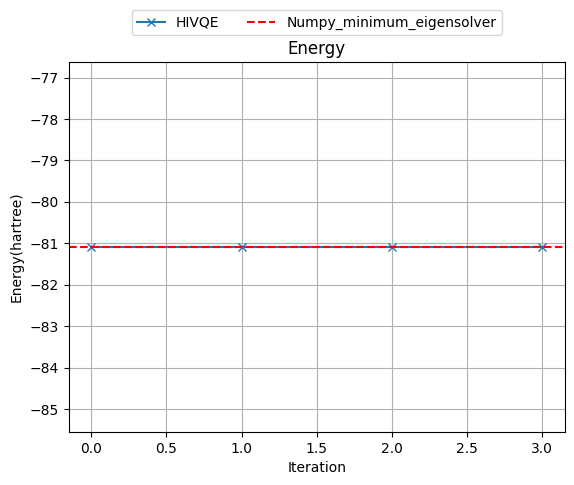

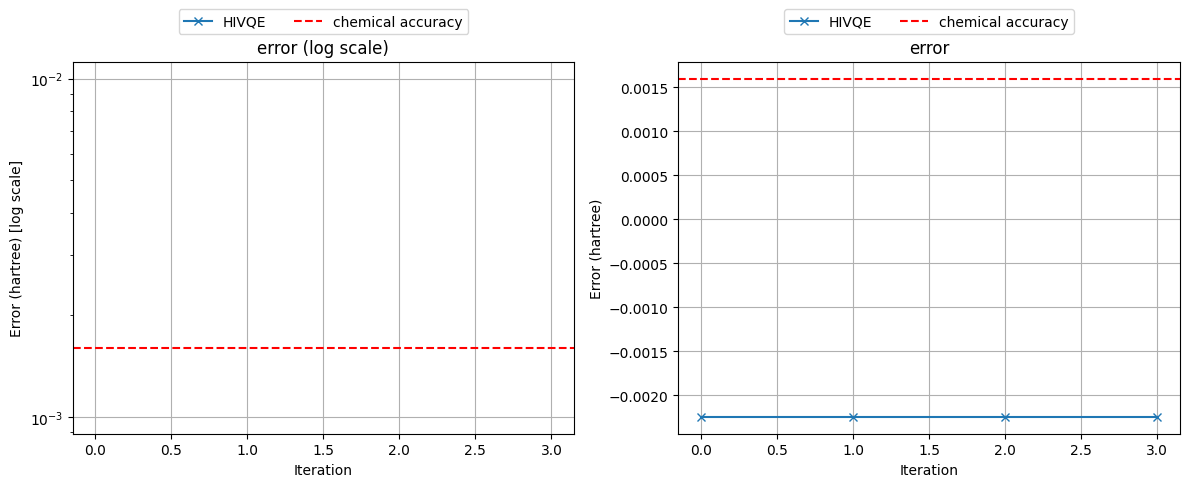

In [10]:
E_1 = HIVQE(as_problem,0,36)

## 2. O--Li(far, non-bonding)

In [11]:
O_Li_dimer_atoms = ["O", "Li"]
O_Li_dimer_coords = [O_2, Li]
O_Li_dimer_charge = 0
O_Li_dimer_multiplicity = 4

O_Li_moleculeinfo = MoleculeInfo(O_Li_dimer_atoms, O_Li_dimer_coords, charge=O_Li_dimer_charge, multiplicity=O_Li_dimer_multiplicity)


driver = PySCFDriver.from_molecule(O_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((4,1), 4)
as_problem = as_transformer.transform(E_problem)

num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)

36


sampled_space :  4
-----------------------
Sampling : 0.154967초
sampled_space 4
Screening : 0.007996초
screened_space 4
energy calc: 0.005914초
post screening: 0.000009초
calssical expansion: 0.000059초
each iteration: 0.169026초
Iter 1: Energy = -81.120087
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.190485초
sampled_space 4
Screening : 0.008233초
screened_space 4
energy calc: 0.005874초
post screening: 0.000010초
calssical expansion: 0.000059초
each iteration: 0.204752초
Iter 2: Energy = -81.120087
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.170907초
sampled_space 4
Screening : 0.007693초
screened_space 4
energy calc: 0.006001초
post screening: 0.000010초
calssical expansion: 0.000059초
each iteration: 0.184766초
Iter 3: Energy = -81.120087
-----------------------
sampled_space :  4
-----------------------
Sampling : 0.176532초
sampled_space 4
Screening : 0.007485초
screened_space 4
energy calc: 0.007830초
post screening: 0.000013초
c

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


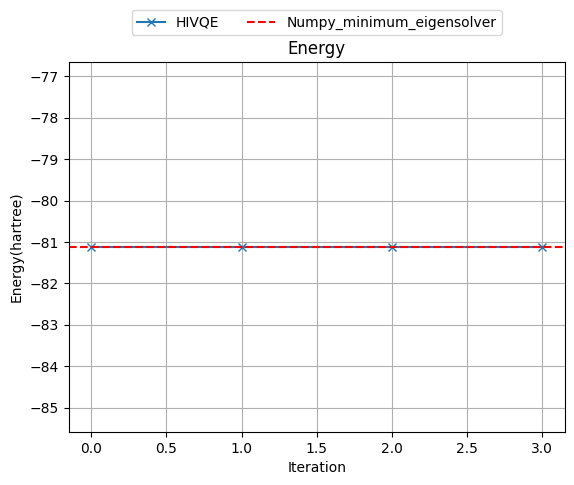

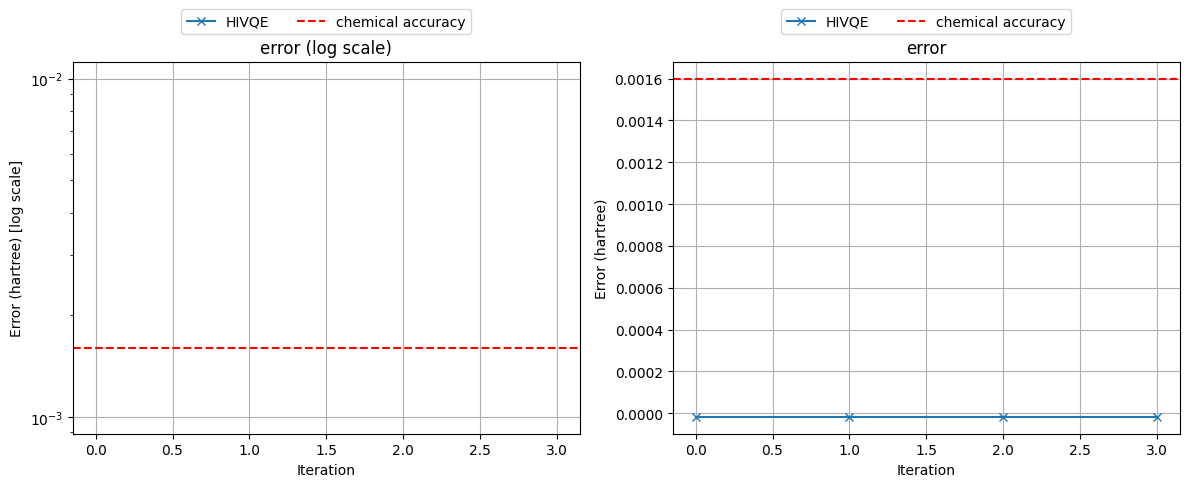

In [12]:
E_2 = HIVQE(as_problem,1,30)

## 3. Co-Li (non-bonding)

In [13]:
Co_Li_dimer_atoms = ["Co", "Li"]
Co_Li_dimer_coords = [Co, Li]
Co_Li_dimer_charge = 0
Co_Li_dimer_multiplicity = 5
energy_arr =[]
order=[]
Co_Li_moleculeinfo = MoleculeInfo(Co_Li_dimer_atoms, Co_Li_dimer_coords, charge=Co_Li_dimer_charge, multiplicity=Co_Li_dimer_multiplicity)



driver = PySCFDriver.from_molecule(Co_Li_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,2), 6)
as_problem = as_transformer.transform(E_problem)

num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)


225


sampled_space :  15
-----------------------
Sampling : 1.113949초
sampled_space 15
Screening : 1.647954초
screened_space 15
energy calc: 1.611746초
post screening: 0.000017초
calssical expansion: 0.000191초
each iteration: 4.374090초
Iter 1: Energy = -1373.595835
-----------------------
sampled_space :  15
-----------------------
Sampling : 1.162454초
sampled_space 15
Screening : 1.638757초
screened_space 15
energy calc: 1.594843초
post screening: 0.000017초
calssical expansion: 0.000189초
each iteration: 4.396492초
Iter 2: Energy = -1373.595835
-----------------------
sampled_space :  15
-----------------------
Sampling : 1.108843초
sampled_space 15
Screening : 1.572460초
screened_space 15
energy calc: 1.568844초
post screening: 0.000017초
calssical expansion: 0.000190초
each iteration: 4.250596초
Iter 3: Energy = -1373.595835
-----------------------
sampled_space :  15
-----------------------
Sampling : 1.109183초
sampled_space 15
Screening : 1.615068초
screened_space 15
energy calc: 1.569070초
post scre

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


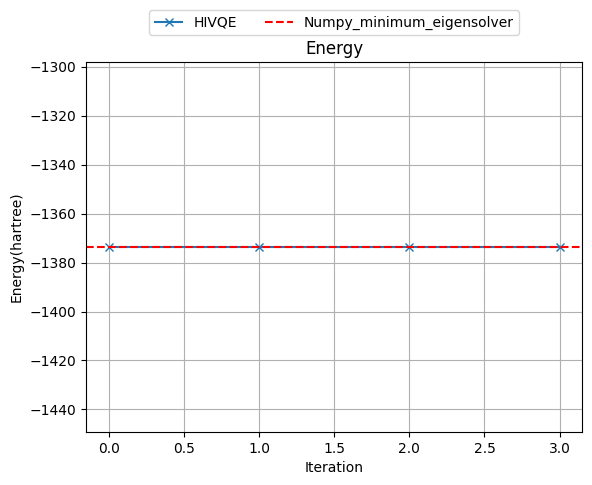

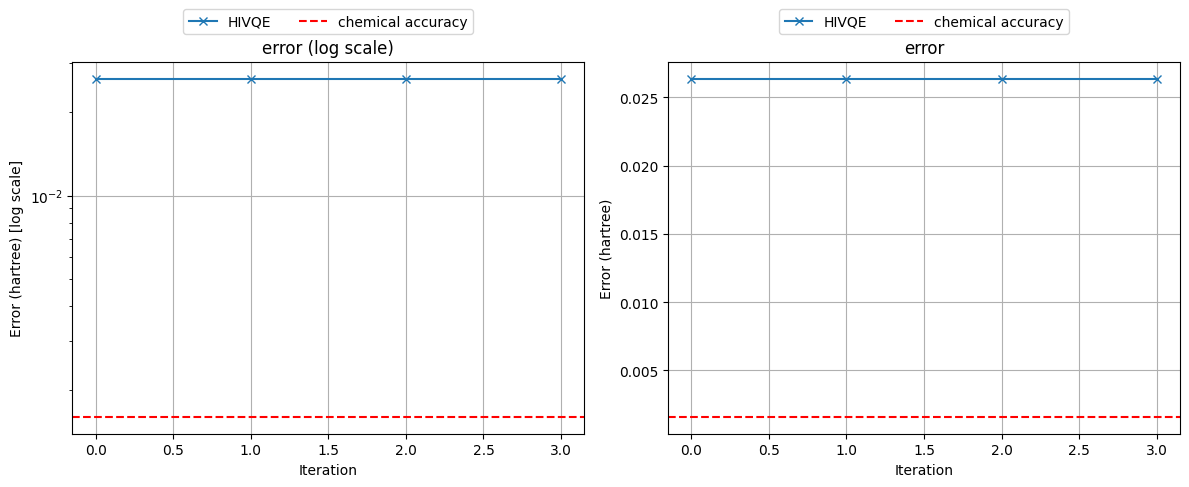

In [14]:
E_3 = HIVQE(as_problem,2,100)

## 4. O-O

In [15]:
O_O_dimer_atoms = ["O", "O"]
O_O_dimer_coords = [O_1, O_2]
O_O_dimer_charge = 0
O_O_dimer_multiplicity = 3
energy_arr =[]
order=[]
O_O_moleculeinfo = MoleculeInfo(O_O_dimer_atoms, O_O_dimer_coords, charge=O_O_dimer_charge, multiplicity=O_O_dimer_multiplicity)

atom = [(O_O_dimer_atoms[0],O_O_dimer_coords[0]),(O_O_dimer_atoms[1],O_O_dimer_coords[1])]

E_FCI = E_NME_List[3]


driver = PySCFDriver.from_molecule(O_O_moleculeinfo, basis=basis)
problem = driver.run()
num_spatial_orbitals = problem.num_spatial_orbitals
as_transformer = ActiveSpaceTransformer((6,2), 6)
as_problem = as_transformer.transform(problem)
num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons)
print(total_dim)


225


In [16]:
E_4 = HIVQE(as_problem,3,100)

sampled_space :  83
-----------------------
Sampling : 1.116582초
sampled_space 83
Screening : 19.546538초
screened_space 83


KeyboardInterrupt: 

## 5. Co=O (Double bonding)

In [ ]:
Co_O_dimer_atoms = ["Co", "O"]
Co_O_dimer_coords = [Co, O_2]

atom = [(Co_O_dimer_atoms[0],Co_O_dimer_coords[0]),(Co_O_dimer_atoms[1],Co_O_dimer_coords[1])]

Co_O_dimer_charge = 0
Co_O_dimer_multiplicity = 2
Co_O_moleculeinfo = MoleculeInfo(Co_O_dimer_atoms, Co_O_dimer_coords, charge=Co_O_dimer_charge, multiplicity=Co_O_dimer_multiplicity)

energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((6,5), 8)
as_problem = as_transformer.transform(E_problem)

num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons) #3136

In [ ]:
E_5 = HIVQE(as_problem,4,500)

-----------------------
Sampling : 14.147419초
sampled_space 1386


KeyboardInterrupt: 

## 6.  Co-O (Single bonding)

In [ ]:
Co_O_dimer_atoms = ["Co", "O"]
Co_O_dimer_coords = [Co, O_1]
Co_O_dimer_charge = 0
Co_O_dimer_multiplicity = 4
Co_O_moleculeinfo = MoleculeInfo(Co_O_dimer_atoms, Co_O_dimer_coords, charge=Co_O_dimer_charge, multiplicity=Co_O_dimer_multiplicity)



energy_arr =[]
order=[]
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run()
num_spatial_orbitals = E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
as_transformer = ActiveSpaceTransformer((7,4), 8)
as_problem = as_transformer.transform(E_problem)

num_spin_orbital = 2*as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles
num_electrons = np.sum(num_particles)
total_dim = calc_total_space(num_spin_orbital,num_electrons) #3136

In [ ]:
E_6 = HIVQE(as_problem,5,500)

In [ ]:
dimer_List = [E_1,E_2,E_3,E_4,E_5,E_6]
print(dimer_List)